#**SHM on open-source Aging Bridge Dataset from Kaggle : using very basic ML to predict degradation score**
Here's a link to the kaggle dataset : [Link to Kaggle Dataset](https://www.kaggle.com/datasets/programmer3/aging-bridge-shm-time-series-dataset)

> This is the most crude basic implementation - haven't considered the time series and not fine-tuned yet

In [ ]:
#import necessary libraries
import pandas as pd #for working with dataframes (tables)
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for static visualizations
import seaborn as sns #built on top of matplotlib - provides high-level interface for statistical graphics

#import necessary functions from certain modules/libraries
from sklearn.model_selection import train_test_split #to split dataset into training and testing sets for ML model
from sklearn.ensemble import RandomForestRegressor #ML algo for predicting continuous values
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error #some evaluation metrics

In [ ]:
#load dataset
df = pd.read_csv('bridge_dataset.csv')

#display the first 5 rows of the dataset
print("\nDataframe Head:")
print(df.head())



Dataframe Head:
             timestamp bridge_id sensor_id  acceleration_x  acceleration_y  \
0  2020-01-01 00:00:00      B001        S4       -0.428902        0.009163   
1  2020-01-01 00:15:00      B003        S3        0.086893       -0.005482   
2  2020-01-01 00:30:00      B003        S3       -0.168531       -0.703500   
3  2020-01-01 00:45:00      B002        S3       -0.242926       -0.046838   
4  2020-01-01 01:00:00      B001        S2        0.175638        0.000792   

   acceleration_z  temperature_c  humidity_percent  wind_speed_mps  \
0       -0.448430      24.263205         82.573476        9.129824   
1        0.422973      19.343838         83.545112        6.676185   
2       -0.403903      18.021082         41.881540        1.084121   
3       -0.359685      19.908278         81.787200        0.003722   
4       -0.242574      30.995286         89.394147        1.032235   

   fft_peak_freq  fft_magnitude  degradation_score  structural_condition  \
0       3.264360 

###**brief breakdown of the columns (features) in given dataset :**
* `timestamp`: date and time of the sensor reading
* `bridge_id`: identifier for the bridge
* `sensor_id`: identifier for the sensor on the bridge
* `acceleration_x`, `acceleration_y`, `acceleration_z`: Acceleration readings along the x, y, and z axes. *These indicate vibrations and movements of the bridge*

* `temperature_c`: temperature in Celsius. *Temperature can affect material properties and cause expansion or contraction*

* `humidity_percent`: relative humidity

* `wind_speed_mps`: wind speed (in meters per second)

* `fft_peak_freq`: peak frequency from a Fast Fourier Transform of the vibration data. *This indicates the natural frequency of the bridge (which can change as the structure degrades)*

* `fft_magnitude`: magnitude of the peak frequency

* `degradation_score`: we'll consider this our target variable. A numerical score representing the level of degradation (higher score means more degradation)

* `structural_condition`: categorical rating of the bridge's condition

* `damage_class`: categorical label for the damage level (e.g., 'No Damage', 'Minor', 'Severe')

* `forecast_score_next_30d`: forecasted degradation score for the next 30 days

In [ ]:
#display basic information about the dataset
print("Dataframe Info:")
df.info()

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                1340 non-null   object 
 1   bridge_id                1340 non-null   object 
 2   sensor_id                1340 non-null   object 
 3   acceleration_x           1340 non-null   float64
 4   acceleration_y           1340 non-null   float64
 5   acceleration_z           1340 non-null   float64
 6   temperature_c            1340 non-null   float64
 7   humidity_percent         1340 non-null   float64
 8   wind_speed_mps           1340 non-null   float64
 9   fft_peak_freq            1340 non-null   float64
 10  fft_magnitude            1340 non-null   float64
 11  degradation_score        1340 non-null   float64
 12  structural_condition     1340 non-null   int64  
 13  damage_class             1340 non-null   object 
 14  forecast

*in the above output we can observe there are no null values in the dataset - this is a plus (if there were null values present, we'd have to handle these: common techniques are deleting the rows with null values or filling the null values with column average, and so on)*

In [ ]:
#display summary statistics
print("Dataframe Description:\n")
print(df.describe())

Dataframe Description:

       acceleration_x  acceleration_y  acceleration_z  temperature_c  \
count     1340.000000     1340.000000     1340.000000    1340.000000   
mean         0.000152       -0.011864        0.000679      25.185745   
std          0.289156        0.293730        0.302737       4.975551   
min         -0.872300       -1.148754       -0.901086       7.199972   
25%         -0.202702       -0.215941       -0.199720      21.700007   
50%          0.001418       -0.005285       -0.002043      25.243176   
75%          0.197210        0.186663        0.204599      28.608905   
max          0.958277        0.918312        1.022132      41.531937   

       humidity_percent  wind_speed_mps  fft_peak_freq  fft_magnitude  \
count       1340.000000     1340.000000    1340.000000    1340.000000   
mean          59.835657        7.602270       2.766077       0.796044   
std           17.406105        4.323423       1.295362       0.400528   
min           30.055872        0.00

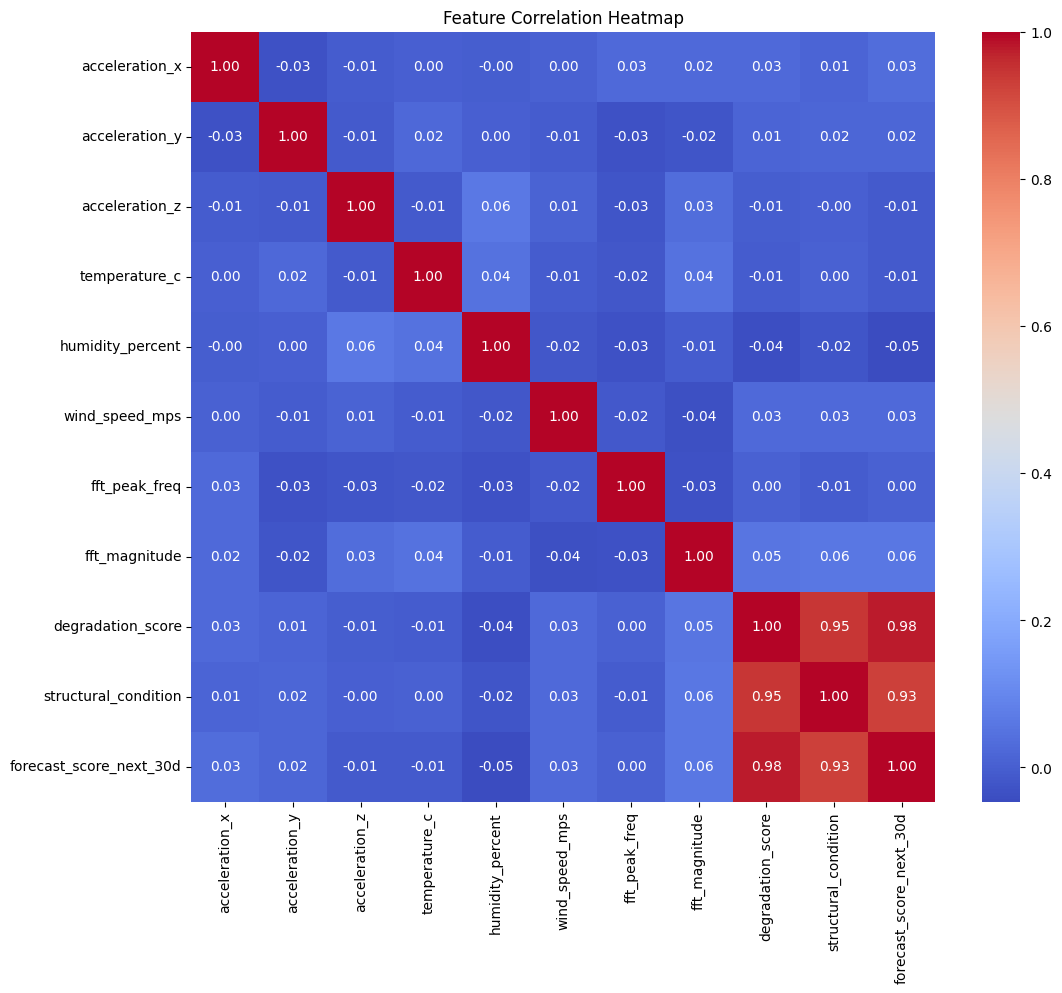

In [ ]:
#feature correlation
#we'll select only numeric columns for correlation matrix for now
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()

#plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

###**ML model for degradation score prediction**

In [ ]:
#feature engineering and selection
df_ml = df.copy() #made a copy of the original dataframe to work on

#encode categorical variables
df_ml = pd.get_dummies(df_ml, columns=['bridge_id', 'sensor_id', 'damage_class'], drop_first=True)

#drop 'timestamp' for this model
#we'll also drop 'structural_condition' and 'forecast_score_next_30d' (these are dependedent on our target variable degradation_score so we won't consider these for training)
df_ml = df_ml.drop(['timestamp', 'structural_condition', 'forecast_score_next_30d'], axis=1)

In [ ]:
#define features (X) and target (y)
X = df_ml.drop('degradation_score', axis=1) #all features except degradation_score
y = df_ml['degradation_score']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

#make predictionsa
y_pred = model.predict(X_test)

In [ ]:
#evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Model Performance:
R-squared: 0.8874
Mean Absolute Error: 6.4629
Root Mean Squared Error: 7.6449


* **R-squared** (R2): Represents the percentage of the target variable's variance that the model can explain. A score closer to 1.0 indicates a better fit.

* **Mean Absolute Error** (MAE): This is the average absolute difference between the predicted and actual values. It's easy to interpret because it's in the same units as the target variable. A lower value is better.

* **Root Mean Squared Error** (RMSE): This is the square root of the average of squared errors. It's also in the same units as the target but penalizes large errors (outliers) much more heavily than MAE. A lower value is better.

###**Visualizations**

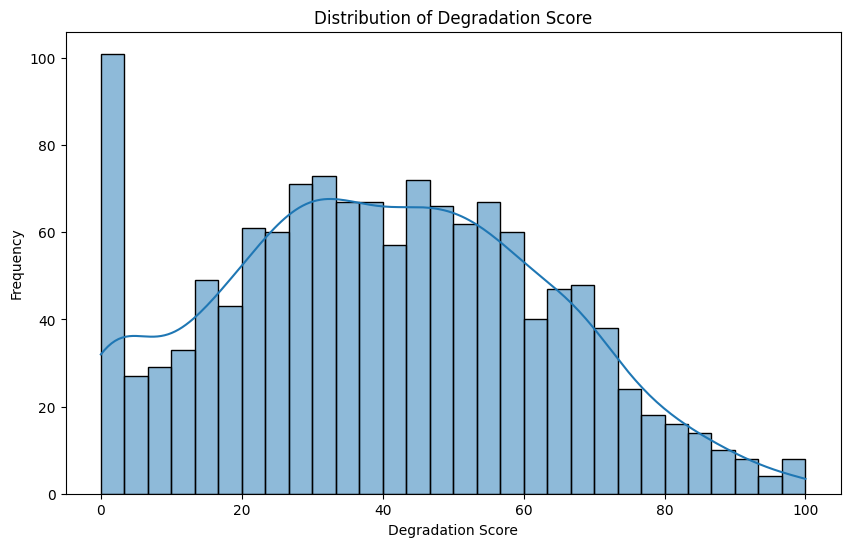

In [ ]:
#distribution of degradation score
plt.figure(figsize=(10, 6))
sns.histplot(df['degradation_score'], kde=True, bins=30)
plt.title('Distribution of Degradation Score')
plt.xlabel('Degradation Score')
plt.ylabel('Frequency')
plt.show()

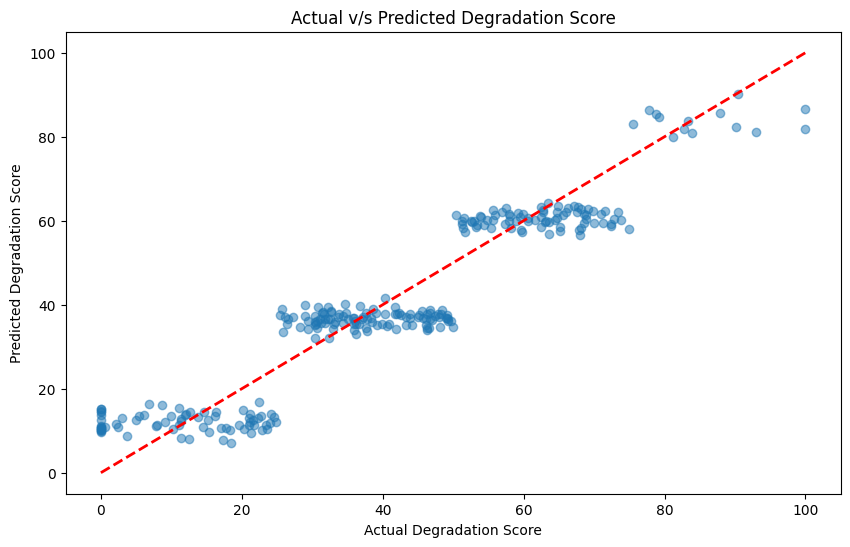

In [ ]:
#actual v/s predicted degradation score
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual v/s Predicted Degradation Score')
plt.xlabel('Actual Degradation Score')
plt.ylabel('Predicted Degradation Score')
plt.show()